In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import BinaryCrossentropy
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DomeKano/DomeKano.csv')

In [ ]:
raw_data.shape

(75, 8)

Let's run the data through ChatGPT to flag duplicate data

In [ ]:
# Delete duplicate rows flagged by ChatGPT
raw_data = raw_data.drop(raw_data.index[[2, 5]])

raw_data.shape

(73, 8)

## Understand and visualize data

In [ ]:
features = ['timestamp', 'gender', 'region', 'age_range', 'time_finished', 'time_reading_manga', 'relationship_values', 'team']

raw_data.columns = features

In [ ]:
raw_data.head()

,timestamp,gender,region,age_range,time_finished,time_reading_manga,relationship_values,team
0,2025/06/18 6:32:59 PM MDT,Male,North America,25 - 34,5+ years,Finished the manga a while ago (3+ years ago),Mutual support and growth,Team Rui
1,2025/06/18 6:33:48 PM MDT,Male,Europe (Including Russia),18 - 24,5+ years,Finished the manga a while ago (3+ years ago),Deep emotional connection,Team Hina
3,2025/06/18 6:38:15 PM MDT,Male,North America,18 - 24,1 - 2 years,Finished the manga recently (less than a year ...,Deep emotional connection,Team Rui
4,2025/06/18 6:40:07 PM MDT,Male,North America,25 - 34,5+ years,Finished the manga a while ago (3+ years ago),Deep emotional connection,Team Hina
6,2025/06/18 7:05:47 PM MDT,Male,North America,18 - 24,1 - 2 years,Finished the manga recently (less than a year ...,Deep emotional connection,Team Rui


In [ ]:
raw_data.describe()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: FutureWarning: Parsed string "2025/06/18 6:32:59 PM MDT" included an un-recognized timezone "MDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,timestamp,gender,region,age_range,time_finished,time_reading_manga,relationship_values,team
count,73,73,73,73,73,73,72,73
unique,73,3,7,5,4,4,4,2
top,2025/06/18 6:32:59 PM MDT,Male,North America,18 - 24,5+ years,Finished the manga a while ago (3+ years ago),Deep emotional connection,Team Rui
freq,1,70,35,29,33,40,36,45


Our data has a slight class imbalance - model predictions will likely lean towards Team Rui

In [ ]:
# Team Rui makes up 61.6% of the dataset
45 / 73 * 100

61.64383561643836

In [ ]:
# Clean up columns
raw_data.drop(columns=['timestamp'], inplace=True)

In [ ]:
data_info = pd.DataFrame({
    'na': raw_data.isna().sum(),
    'unique': raw_data.nunique(),
    'type': raw_data.dtypes
})

data_info

,na,unique,type
gender,0,3,object
region,0,7,object
age_range,0,5,object
time_finished,0,4,object
time_reading_manga,0,4,object
relationship_values,1,4,object
team,0,2,object


In [ ]:
# Find the most frequent value in 'relationship_values' to fill na
most_frequent = raw_data['relationship_values'].mode()[0]

raw_data['relationship_values'] = raw_data['relationship_values'].fillna(most_frequent)

In [ ]:
# Visualize our data side-by-side
columns = ['region', 'age_range', 'time_reading_manga', 'relationship_values', 'time_finished', 'gender']

team_rui = raw_data[raw_data['team'] == 'Team Rui']
team_hina = raw_data[raw_data['team'] == 'Team Hina']

for col in columns:
    rui_counts = team_rui[col].value_counts()
    hina_counts = team_hina[col].value_counts()

    combined = pd.DataFrame({
        'Team Rui': rui_counts,
        'Team Hina': hina_counts
    }).fillna(0).astype(int)

    print(combined)
    print()

                                                    Team Rui  Team Hina
region                                                                 
East Asia (China, Japan, Korea, Taiwan, etc.)              1          2
Europe (Including Russia)                                 13          9
North America                                             26          9
Oceania                                                    1          1
South America                                              1          0
South Asia (India, Pakistan, Bangladesh, Sri La...         2          5
Southeast Asia (Philippines, Indonesia, Vietnam...         1          2

           Team Rui  Team Hina
age_range                     
13 - 17          10          1
18 - 24          19         10
25 - 34          13          9
35 - 44           3          5
45+               0          3

                                                    Team Rui  Team Hina
time_reading_manga                                           

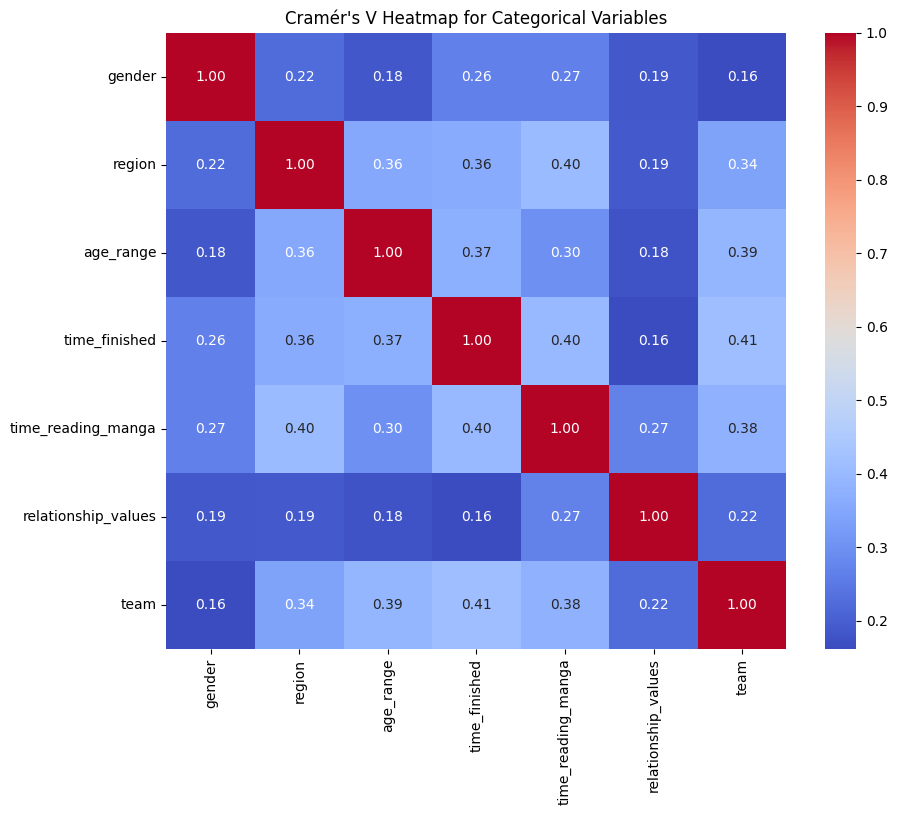

In [ ]:
# Define function for Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Select categorical columns
categorical_cols = raw_data.select_dtypes(include=['object', 'category']).columns

# Create empty DataFrame for results
cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Compute pairwise Cramér's V
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_results.loc[col1, col2] = 1.0  # perfect association with self
        else:
            cramers_results.loc[col1, col2] = cramers_v(raw_data[col1], raw_data[col2])

# Convert to float
cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cramér's V Heatmap for Categorical Variables")
plt.show()


## Preprocess data for training

In [ ]:
x_input = raw_data.drop(columns=['team'])
y_input = raw_data['team']

In [ ]:
x_input.head()

,gender,region,age_range,time_finished,time_reading_manga,relationship_values
0,Male,North America,25 - 34,5+ years,Finished the manga a while ago (3+ years ago),Mutual support and growth
1,Male,Europe (Including Russia),18 - 24,5+ years,Finished the manga a while ago (3+ years ago),Deep emotional connection
3,Male,North America,18 - 24,1 - 2 years,Finished the manga recently (less than a year ...,Deep emotional connection
4,Male,North America,25 - 34,5+ years,Finished the manga a while ago (3+ years ago),Deep emotional connection
6,Male,North America,18 - 24,1 - 2 years,Finished the manga recently (less than a year ...,Deep emotional connection


Encode data using a nominal/ordinal feature type criteria. We can consolidate categories with only 1 or 2 responses to avoid overfitting

In [ ]:
# Consolidate South Asia, Southeast Asia, East Asia
# Combine countries with low representation into 'other'
# remap_region = {
#     'South Asia (India, Pakistan, Bangladesh, Sri Lanka)': 'Asia',
#     'Southeast Asia (Philippines, Indonesia, Vietnam, etc.)': 'Asia',
#     'East Asia (China, Japan, Korea, Taiwan, etc.)': 'Asia',
#     'Oceania': 'Other',
#     'South America': 'Other'
# }

# List ordinal categories for encoding
categories = [
    ['13 - 17', '18 - 24', '25 - 34', '35 - 44', '45+'],
    ['Less than a year', '1 - 2 years', '3 - 5 years', '5+ years'],
    ['Not familiar/just curious',
     'Have only seen the anime adaptation',
     'Finished the manga recently (less than a year - 2 years ago)',
     'Finished the manga a while ago (3+ years ago)']
]

remap_gender = {
    'Female': 'Not Male',
    'Non-binary/other': 'Not Male'
}
x_input['gender'] = x_input['gender'].replace(remap_gender)

# Encode nominal data
nominal_cols = ['gender', 'region', 'relationship_values']
nominal_cols = [col for col in nominal_cols if col in x_input.columns]

# x_input['region'] = x_input['region'].replace(remap_region)
df_nominal = pd.get_dummies(x_input[nominal_cols], dtype=int)
df_nominal.index = x_input.index

# Encode ordinal data
ordinal_cols = ['age_range', 'time_finished', 'time_reading_manga']

encoder = OrdinalEncoder(categories=categories)
ordinal = encoder.fit_transform(x_input[ordinal_cols])
df_ordinal = pd.DataFrame(ordinal, columns=ordinal_cols, index=x_input.index)
df_ordinal.columns = ordinal_cols

# Combine encoded data
x_data = pd.concat([df_ordinal, df_nominal], axis=1)

le = LabelEncoder()
y_data = le.fit_transform(y_input)

In [ ]:
x_data.head()

,age_range,time_finished,time_reading_manga,gender_Male,gender_Not Male,"region_East Asia (China, Japan, Korea, Taiwan, etc.)",region_Europe (Including Russia),region_North America,region_Oceania,region_South America,"region_South Asia (India, Pakistan, Bangladesh, Sri Lanka)","region_Southeast Asia (Philippines, Indonesia, Vietnam, etc.)",relationship_values_Deep emotional connection,relationship_values_Exciting physical chemistry,relationship_values_Mutual support and growth,relationship_values_Stability and reliability
0,2.0,3.0,3.0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,1.0,3.0,3.0,1,0,0,1,0,0,0,0,0,1,0,0,0
3,1.0,1.0,2.0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,2.0,3.0,3.0,1,0,0,0,1,0,0,0,0,1,0,0,0
6,1.0,1.0,2.0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [ ]:
# Function for creating and training models with hyperparameter tuning
# Use Decision Tree, Logistic Regression, XGBoost, and Random Forest algorithms
def train_models(x_input, y_input, model='dt', class_weight=None):
    if model == 'dt':
        dt = tree.DecisionTreeClassifier(random_state=1, class_weight=class_weight)
        param_grid = {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10]
        }
        grid = GridSearchCV(dt, param_grid, cv=5)
        grid.fit(x_input, y_input)
        best_model = grid.best_estimator_

    elif model == 'lr':
        lr = LogisticRegression(max_iter=2000, class_weight=class_weight)
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
        grid = GridSearchCV(lr, param_grid, cv=5)
        grid.fit(x_input, y_input)
        best_model = grid.best_estimator_

    elif model == 'xgb':
        pos_weight = class_weight[1] / class_weight[0] if class_weight else 1
        xgb = XGBClassifier(random_state=1, eval_metric='logloss', scale_pos_weight=pos_weight)
        param_grid = {
            'max_depth': [3, 5, 7],
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
        grid = GridSearchCV(xgb, param_grid, cv=5)
        grid.fit(x_input, y_input)
        best_model = grid.best_estimator_

    elif model == 'rf':
        rf = RandomForestClassifier(random_state=1, class_weight=class_weight)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        grid = GridSearchCV(rf, param_grid, cv=5)
        grid.fit(x_input, y_input)
        best_model = grid.best_estimator_

    return best_model, grid.best_score_, grid.best_params_

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data,
    stratify=y_data,
    random_state=3,
    test_size=0.2,
    shuffle=True
)

## Build and train Decision Tree, Logistic Regression, XGboost, and Random Forest models

Since we have a small dataset, lets prioritize CV score for hyperparameter tuning and model evaluation

In [ ]:
# Address imbalance in dataset by using class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Avoid class weights for Decision Tree model
dt, dt_cv_score, dt_cv_params = train_models(x_train, y_train, model='dt')
dt_test_predictions = dt.predict(x_test).flatten()

dt_test_results = pd.DataFrame({
    'Train Predictions': dt_test_predictions,
    'Actual': y_test.flatten()
})

dt_accuracy = accuracy_score(dt_test_results['Actual'], dt_test_results['Train Predictions'])
dt_f1 = f1_score(dt_test_results['Actual'], dt_test_results['Train Predictions'])
dt_roc_auc = roc_auc_score(y_test, dt_test_predictions)

print(f'Best cross-validation score: {dt_cv_score:.4f}')
print(f'Best params: {dt_cv_params}\n')

print('Decision Tree y_test score:')
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"F1 Score: {dt_f1:.4f}")
print("AUC:", dt_roc_auc)

Best cross-validation score: 0.7606
Best params: {'max_depth': 5, 'min_samples_split': 5}

Decision Tree y_test score:
Accuracy: 0.7333
F1 Score: 0.8000
AUC: 0.6944444444444444


In [ ]:
lr, lr_cv_score, lr_cv_params = train_models(x_train, y_train, model='lr')
lr_test_predictions = lr.predict(x_test).flatten()

lr_test_results = pd.DataFrame({
    'Train Predictions': lr_test_predictions,
    'Actual': y_test.flatten()
})

lr_accuracy = accuracy_score(lr_test_results['Actual'], lr_test_results['Train Predictions'])
lr_f1 = f1_score(lr_test_results['Actual'], lr_test_results['Train Predictions'])
lr_roc_auc = roc_auc_score(y_test, lr_test_predictions)

print(f'Best cross-validation score: {lr_cv_score:.4f}')
print(f'Best params: {lr_cv_params}\n')

print('Logistic Regression y_test score:')
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print("AUC:", lr_roc_auc)

Best cross-validation score: 0.7242
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Logistic Regression y_test score:
Accuracy: 0.6000
F1 Score: 0.7000
AUC: 0.5555555555555556


In [ ]:
xgb, xgb_cv_score, xgb_cv_params = train_models(x_train, y_train, model='xgb')
xgb_test_predictions = xgb.predict(x_test).flatten()

xgb_test_results = pd.DataFrame({
    'Train Predictions': xgb_test_predictions,
    'Actual': y_test.flatten()
})

xgb_accuracy = accuracy_score(xgb_test_results['Actual'], xgb_test_results['Train Predictions'])
xgb_f1 = f1_score(xgb_test_results['Actual'], xgb_test_results['Train Predictions'])
xgb_roc_auc = roc_auc_score(y_test, xgb_test_predictions)

print(f'Best cross-validation score: {xgb_cv_score:.4f}')
print(f'Best params: {xgb_cv_params}\n')

print('XGBoost y_test score:')
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print("AUC:", xgb_roc_auc)

Best cross-validation score: 0.8091
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

XGBoost y_test score:
Accuracy: 0.6667
F1 Score: 0.7619
AUC: 0.6111111111111112


In [ ]:
rf, rf_cv_score, rf_cv_params = train_models(x_train, y_train, model='rf')
rf_test_predictions = rf.predict(x_test).flatten()

rf_test_results = pd.DataFrame({
    'Train Predictions': rf_test_predictions,
    'Actual': y_test.flatten()
})

rf_accuracy = accuracy_score(rf_test_results['Actual'], rf_test_results['Train Predictions'])
rf_f1 = f1_score(rf_test_results['Actual'], rf_test_results['Train Predictions'])
rf_roc_auc = roc_auc_score(y_test, rf_test_predictions)

print(f'Best cross-validation score: {rf_cv_score:.4f}')
print(f'Best params: {rf_cv_params}\n')

print('Random Forest y_test score:')
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("AUC:", rf_roc_auc)

Best cross-validation score: 0.8439
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest y_test score:
Accuracy: 0.6667
F1 Score: 0.7619
AUC: 0.6111111111111112


## Attempt to build a neural network

Neural Networks perform poorly on small datasets, but lets try anyway

In [ ]:
# Neural Networks perform poorly on small datasets, but lets try anyway
nn = Sequential()
nn.add(Dense(
    input_shape=(x_train.shape[1],),
    units=16,
    activation='relu'
)),
nn.add(Dense(
    units=8,
    activation='relu'
))
nn.add(Dense(
    units=1,
    activation='sigmoid'
))

nn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy'])

nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417 (1.63 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = nn.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.6221 - loss: 0.7431 - val_accuracy: 0.6000 - val_loss: 0.6910
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6325 - loss: 0.7302 - val_accuracy: 0.6000 - val_loss: 0.6884
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6013 - loss: 0.7492 - val_accuracy: 0.6000 - val_loss: 0.6860
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6221 - loss: 0.7338 - val_accuracy: 0.6000 - val_loss: 0.6838
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6117 - loss: 0.7280 - val_accuracy: 0.6000 - val_loss: 0.6818
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6534 - loss: 0.7014 - val_accuracy: 0.6000 - val_loss: 0.6804
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6221 - loss: 0.7182 - val_accuracy: 0.6000 - val_loss: 0.6792
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6534 - loss: 0.6960 - val_accuracy: 0.6000 - val_loss: 0.678

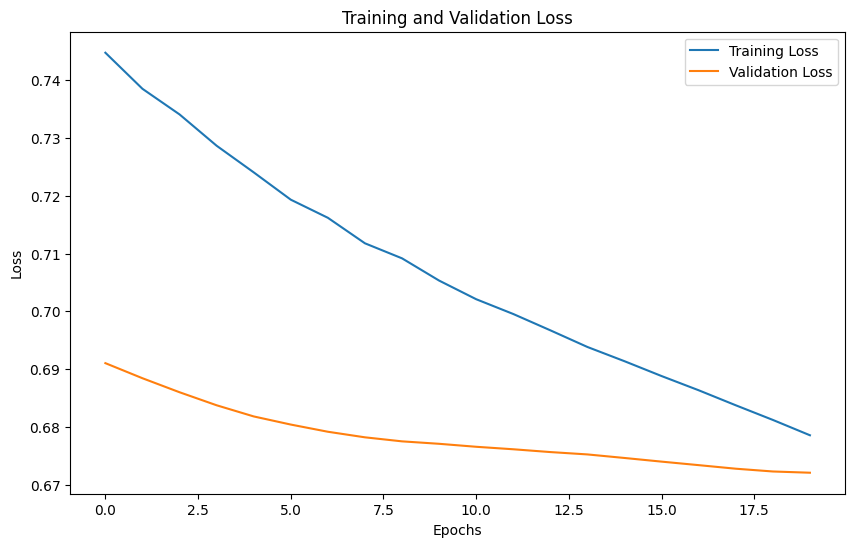

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predicted probabilities and binary labels
y_pred_probs = nn.predict(x_test).flatten()
nn_test_predictions = (y_pred_probs >= 0.5).astype(int)

# Create a DataFrame with predictions and actual values
nn_test_results = pd.DataFrame({
    'Train Predictions': nn_test_predictions,
    'Actual': y_test.flatten()
})

# Compute evaluation metrics
nn_accuracy = accuracy_score(nn_test_results['Actual'], nn_test_results['Train Predictions'])
nn_f1 = f1_score(nn_test_results['Actual'], nn_test_results['Train Predictions'])
nn_roc_auc = roc_auc_score(y_test, nn_test_predictions)

print('Random Forest y_test score:')
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"F1 Score: {nn_f1:.4f}")
print("AUC:", nn_roc_auc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Random Forest y_test score:
Accuracy: 0.6000
F1 Score: 0.7500
AUC: 0.5


## Test model results on y_test



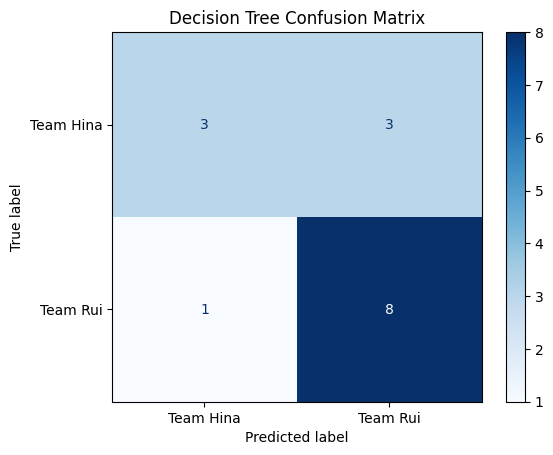

In [ ]:
cm = confusion_matrix(y_test, dt_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

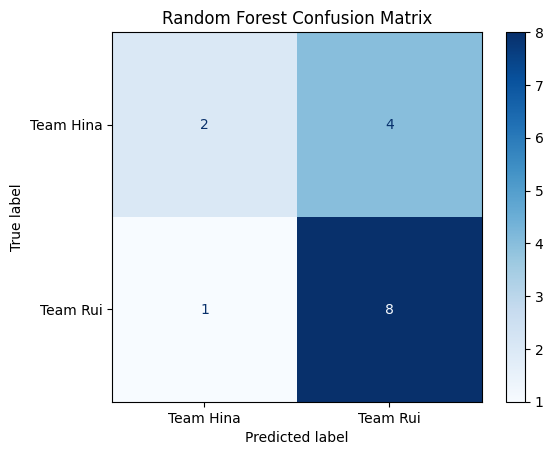

In [ ]:
cm = confusion_matrix(y_test, rf_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

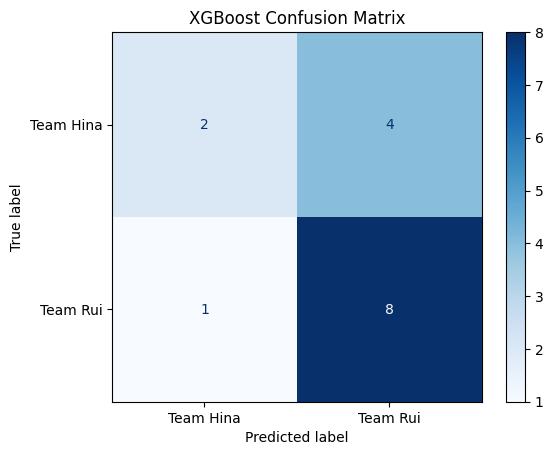

In [ ]:
cm = confusion_matrix(y_test, xgb_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

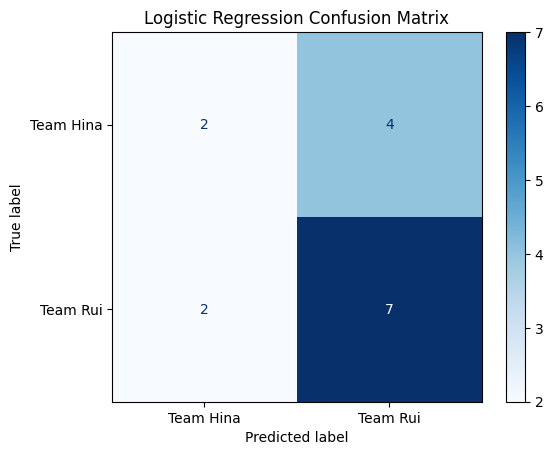

In [ ]:
cm = confusion_matrix(y_test, lr_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

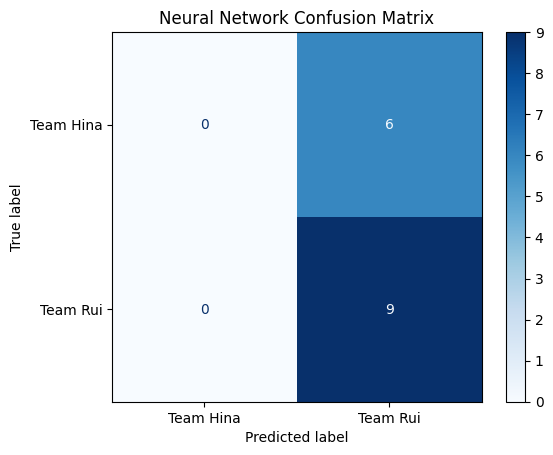

In [ ]:
cm = confusion_matrix(y_test, nn_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Neural Network Confusion Matrix")
plt.show()

## Conclusion

In this notebook, we trained models using the Decision Tree, Random Forest, Logistic Regression, XGBoost algorithims and built a Neural Network. The Random Forest model had the strongest overall performance, achieving 67% accuracy, an F1 score of 0.7619, an ROC_AUC score of 0.6111 on the test data (14 responses), and a five-fold CV score of 0.8439.

Some limitations we encountered include an imbalanced dataset (62% Rui, 38% Hina) and a small sample size of only 73 responses. To address these challenges, we:
- Prioritized cross-validation scores over test metrics for evaluation
- Built lighter models with conservative hyperparameter settings (e.g., low max_depth)
- Applied class weighting to mitigate the effects of class imbalance

In [ ]:
model_metrics = {
    'Model': ['Decision Tree', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy': [dt_accuracy, lr_accuracy, rf_accuracy, xgb_accuracy, nn_accuracy],
    'F1 Score': [dt_f1, lr_f1, rf_f1, xgb_f1, nn_f1],
    'AUC': [dt_roc_auc, lr_roc_auc, rf_roc_auc, xgb_roc_auc, nn_roc_auc],
    'CV Score': [dt_cv_score, lr_cv_score, rf_cv_score, xgb_cv_score, np.nan]
}

results_df = pd.DataFrame(model_metrics)
results_df = results_df.sort_values(by='CV Score', ascending=False).reset_index(drop=True)

results_df

,Model,Accuracy,F1 Score,AUC,CV Score
0,Random Forest,0.666667,0.761905,0.611111,0.843939
1,XGBoost,0.666667,0.761905,0.611111,0.809091
2,Decision Tree,0.733333,0.800000,0.694444,0.760606
3,Logistic Regression,0.600000,0.700000,0.555556,0.724242
4,Neural Network,0.600000,0.750000,0.500000,NaN


## Interactive predictions

In [ ]:
# --- Layout ---
widget_layout = widgets.Layout(width='40%', height='35px')
dropdown_style = {'description_width': '160px'}
button_layout = widgets.Layout(width='20%', height='40px')

# --- User input widgets ---
gender_widget = widgets.Dropdown(
    options=['Male', 'Female', 'Non-binary/other'],
    description='🧑 Gender:',
    layout=widget_layout,
    style=dropdown_style
)

region_widget = widgets.Dropdown(
    options=[
        'North America',
        'Europe (Including Russia)',
        'South Asia (India, Pakistan, Bangladesh, Sri Lanka)',
        'Southeast Asia (Philippines, Indonesia, Vietnam, etc.)',
        'East Asia (China, Japan, Korea, Taiwan, etc.)',
        'Oceania',
        'South America'
    ],
    description='🌍 Region:',
    layout=widget_layout,
    style=dropdown_style
)

age_widget = widgets.Dropdown(
    options=['13 - 17', '18 - 24', '25 - 34', '35 - 44', '45+'],
    description='👤 Age range:',
    layout=widget_layout,
    style=dropdown_style
)

finished_widget = widgets.Dropdown(
    options=['Less than a year', '1 - 2 years', '3 - 5 years', '5+ years'],
    description='📅 Time reading manga:',
    layout=widget_layout,
    style=dropdown_style
)

reading_widget = widgets.Dropdown(
    options=[
        'Not familiar/just curious',
        'Have only seen the anime adaptation',
        'Finished the manga recently (less than a year - 2 years ago)',
        'Finished the manga a while ago (3+ years ago)'
    ],
    description='📖 Familiarity:',
    layout=widget_layout,
    style=dropdown_style
)

relationship_widget = widgets.Dropdown(
    options=[
        'Mutual support and growth',
        'Deep emotional connection',
        'Exciting physical chemistry',
        'Stability and reliability'
    ],
    description='❤️ Relationship values:',
    layout=widget_layout,
    style=dropdown_style
)

predict_button = widgets.Button(
    description='Predict!',
    button_style='primary',
    layout=button_layout
)

output = widgets.Output()

# --- Callback ---
def on_predict_clicked(b):
    with output:
        clear_output()

        # Get input
        new_example = {
            'gender': gender_widget.value,
            'region': region_widget.value,
            'relationship_values': relationship_widget.value,
            'age_range': age_widget.value,
            'time_finished': finished_widget.value,
            'time_reading_manga': reading_widget.value
        }

        df_new = pd.DataFrame([new_example])

        # df_new['region'] = df_new['region'].replace(remap_region)
        df_new['gender'] = df_new['gender'].replace(remap_gender)

        # Nominal encoding:
        df_nominal_new = pd.get_dummies(df_new[nominal_cols], dtype=int)
        for col in df_nominal.columns:
            if col not in df_nominal_new.columns:
                df_nominal_new[col] = 0
        df_nominal_new = df_nominal_new[df_nominal.columns]

        # Ordinal encoding
        df_ordinal_new = pd.DataFrame(
            encoder.transform(df_new[ordinal_cols]),
            columns=ordinal_cols,
            index=df_new.index
        )

        x_new = pd.concat([df_ordinal_new, df_nominal_new], axis=1)

        # --- Make predictions with each model ---
        models = {
            'Random Forest': rf,
            'XGBoost': xgb,
            'Decision Tree': dt,
            'Logistic Regression': lr,
            'Neural Network': nn
        }

        class_names = ['Hina', 'Rui']
        results = []

        for name, model in models.items():
            if name == 'Neural Network':
                proba = model.predict(x_new)[0][0]  # Single probability
                pred = int(proba >= 0.5)  # Convert to binary class
                proba_str = {
                    'P(Hina)': f"{1 - proba:.4f}",
                    'P(Rui)': f"{proba:.4f}"
                }
            elif name == 'Decision Tree':
                pred = model.predict(x_new)[0]
                proba_str = {'P(Hina)': '-', 'P(Rui)': '-'}
            else:
                pred = model.predict(x_new)[0]
                proba = model.predict_proba(x_new)[0]
                proba_str = {
                    'P(Hina)': f"{proba[0]:.4f}",
                    'P(Rui)': f"{proba[1]:.4f}"
                }

            if name == 'Random Forest':
                results.append({
                    'Model': f'🏆 {name}',
                    'Prediction': class_names[pred],
                    **proba_str
                })
            else:
                results.append({
                    'Model': name,
                    'Prediction': class_names[pred],
                    **proba_str
                })

        print()
        results_df = pd.DataFrame(results)

        # Display results
        display(results_df.style.set_table_attributes("style='display:inline'").set_caption("Model Comparisons"))

# --- Bind and display ---
predict_button.on_click(on_predict_clicked)

display(
    widgets.VBox([
        widgets.HTML("<h2>🔍 Model Predictions Based on Your Inputs</h2>"),
        gender_widget,
        region_widget,
        age_widget,
        finished_widget,
        reading_widget,
        relationship_widget,
        widgets.HTML("<br>"),
        predict_button,
        widgets.HTML("<br>"),
        output
    ])
)
